# RNN Intent Classification for Changi Airport Virtual Assist / Ops
**CVNL Assignment - RNN Text Sequence Classification**

**Student:** Nur Asyira Fitri Binte Razali (S10270371F)

---

## Assignment Context

This notebook implements the **RNN portion** of the CVNL Assignment on "AI for Changi Airport Passenger Experience & Airside Efficiency". The goal is to develop an RNN-based text classification system that can automatically triage passenger queries.

### Real-World Problem
Changi Airport receives thousands of passenger queries daily via chat, email, and kiosks. Manual routing is slow and resource-intensive. An automated intent classification system can:
- Route queries to appropriate departments instantly
- Provide 24/7 consistent service quality
- Generate analytics for resource planning
- Reduce frontline staff workload

### Implementation Approach
Following the assignment's recommended iterative approach:
1. Dataset selection and justification (ATIS - aviation domain)
2. Baseline model development (simple RNN)
3. Iterative improvements with documented justification
4. Comprehensive evaluation with confusion matrices
5. Final model selection based on performance + stability

---

## 1. Setup and Configuration

### Required Libraries
- PyTorch: Neural network framework
- HuggingFace Datasets: For ATIS dataset
- Scikit-learn: Evaluation metrics
- Matplotlib/Seaborn: Visualization

In [1]:
# ============================================================================
# SETUP AND IMPORTS
# ============================================================================

# Standard imports
import pandas as pd
import numpy as np
from collections import Counter
import json
import os
import random

# Dataset
from datasets import load_dataset

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Evaluation
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report,
    f1_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# ============================================================================
# REPRODUCIBILITY SETUP
# ============================================================================

def set_seed(seed=42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

SEED = 42
set_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('analysis', exist_ok=True)
os.makedirs('confusion_matrices', exist_ok=True)

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Using device: cuda


---

## 2. Dataset Selection & Justification

### Why ATIS Dataset?

**Assignment Requirement:** Select from ATIS, SNIPS, or Twitter US Airline Sentiment

**Selection: ATIS (Air Travel Information System)**

#### Justification:

1. **Aviation Domain Relevance**
   - Contains real air travel queries (flight bookings, gate info, ground services)
   - Directly applicable to Changi Airport passenger assistance scenarios
   - Pre-labeled with intent categories

2. **Dataset Characteristics**
   - **Source:** Airline Travel Information System
   - **Size:** 4,978 training samples, 893 test samples
   - **Format:** Text queries with intent labels
   - **Adaptation:** Use 8 Changi-relevant categories out of 22 intent

3. **Real-World Application at Changi**
   - Passenger queries via chat, email, or kiosks are automatically classified
   - Routes to appropriate department (baggage services, special assistance, etc.)
   - Provides instant automated responses for common queries
   - Generates analytics on query patterns for resource planning

4. **Business Impact**
   - Faster response times (reduce from minutes to seconds)
   - 24/7 consistent service quality
   - Better resource allocation based on demand patterns

### Selected 8 Intent Categories

Chosen to align with Changi Airport use cases:

1. **flight** - Flight status/gate changes (most common)
2. **airfare** - Pricing queries
3. **airline** - Airline information
4. **ground_service** - Ground transport
5. **airport** - Terminal directions
6. **aircraft** - Aircraft information
7. **flight_time** - Flight timing
8. **capacity** - Seating/capacity (relates to special assistance)

In [2]:
# ============================================================================
# LOAD ATIS DATASET AND SELECT 8 AVIATION-RELEVANT INTENTS
# ============================================================================

print("\n" + "="*80)
print("LOADING ATIS DATASET AND SELECTING 8 INTENTS")
print("="*80)

# Load ATIS dataset
dataset = load_dataset("tuetschek/atis")

# Extract training and test splits
train_data_full = dataset['train']
test_data_full = dataset['test']

print(f"\nFull dataset - Training samples: {len(train_data_full)}")
print(f"Full dataset - Test samples: {len(test_data_full)}")

# Determine text and label fields
text_field = 'text'
label_field = 'intent'

# Get all intents from the full dataset
all_intents_full = [sample[label_field] for sample in train_data_full]
intent_counts_full = Counter(all_intents_full)

print("\nAll available intents in ATIS dataset:")
for intent, count in sorted(intent_counts_full.items(), key=lambda x: x[1], reverse=True):
    print(f"  {intent:<30} {count:>5} samples")

# SELECT 8 AVIATION-RELEVANT INTENTS (matching Changi Airport use case)
SELECTED_INTENTS = [
    'flight',           # Most common - flight status/gate changes
    'airfare',          # Pricing queries
    'airline',          # Airline information  
    'ground_service',   # Ground transport
    'airport',          # Terminal directions
    'aircraft',         # Aircraft information
    'flight_time',      # Flight timing
    'capacity'          # Seating/capacity (relates to special assistance)
]

print("\n" + "="*80)
print(f"SELECTED {len(SELECTED_INTENTS)} AVIATION-RELEVANT INTENTS:")
print("="*80)
for i, intent in enumerate(SELECTED_INTENTS, 1):
    count = intent_counts_full.get(intent, 0)
    print(f"{i}. {intent:<30} {count:>5} samples")

# Filter datasets to only include selected intents
def filter_by_intents(data, selected_intents, label_field):
    filtered = []
    for sample in data:
        if sample[label_field] in selected_intents:
            filtered.append(sample)
    return filtered

train_data_raw = filter_by_intents(train_data_full, SELECTED_INTENTS, label_field)
test_data_raw = filter_by_intents(test_data_full, SELECTED_INTENTS, label_field)

print(f"\nFiltered dataset - Training samples: {len(train_data_raw)}")
print(f"Filtered dataset - Test samples: {len(test_data_raw)}")

# Convert to standard format
train_data = train_data_raw
test_data = test_data_raw

# Create intent mappings
intent_list = sorted(SELECTED_INTENTS)  # Sort for consistency
num_classes = len(intent_list)
intent2idx = {intent: idx for idx, intent in enumerate(intent_list)}
idx2intent = {idx: intent for intent, idx in intent2idx.items()}

print(f"\nNumber of classes: {num_classes}")
print("Intent to Index mapping:")
for intent, idx in sorted(intent2idx.items()):
    print(f"  {idx}: {intent}")

# Analyze class distribution
train_intents = [sample[label_field] for sample in train_data]
intent_counts = Counter(train_intents)

print("\nClass Distribution (Training Set):")
for intent in intent_list:
    count = intent_counts[intent]
    percentage = 100 * count / len(train_intents)
    print(f"  {intent:<30} {count:>5} samples ({percentage:>5.1f}%)")

# Calculate class weights for handling imbalance
class_counts = [intent_counts[intent] for intent in intent_list]
total_samples = sum(class_counts)
class_weights = torch.FloatTensor([
    total_samples / (num_classes * count) if count > 0 else 1.0 
    for count in class_counts
]).to(device)

print(f"\nUsing weighted loss to handle class imbalance")
print("Class weights:")
for i, (intent, weight) in enumerate(zip(intent_list, class_weights)):
    print(f"  {intent:<30} weight: {weight:.3f}")


LOADING ATIS DATASET AND SELECTING 8 INTENTS

Full dataset - Training samples: 4978
Full dataset - Test samples: 893

All available intents in ATIS dataset:
  flight                          3666 samples
  airfare                          423 samples
  ground_service                   255 samples
  airline                          157 samples
  abbreviation                     147 samples
  aircraft                          81 samples
  flight_time                       54 samples
  quantity                          51 samples
  flight+airfare                    21 samples
  airport                           20 samples
  distance                          20 samples
  city                              19 samples
  ground_fare                       18 samples
  capacity                          16 samples
  flight_no                         12 samples
  meal                               6 samples
  restriction                        6 samples
  airline+flight_no                  2 samp

---

## 3. Data Preprocessing

### Preprocessing Steps

1. **Vocabulary Building**
   - Build vocabulary from training data only
   - Include special tokens: `<PAD>` (padding), `<UNK>` (unknown)
   - Lowercase all tokens for consistency

2. **Tokenization**
   - Split text into tokens (simple whitespace splitting)
   - Convert tokens to indices using vocabulary

3. **Sequence Padding/Truncation**
   - Fixed sequence length: 50 tokens
   - Pad shorter sequences with `<PAD>` token
   - Truncate longer sequences to max length

4. **Dataset & DataLoader Creation**
   - Custom PyTorch Dataset class
   - Batch size: 32
   - Shuffle training data, keep test data ordered

In [3]:
# ============================================================================
# BUILD VOCABULARY
# ============================================================================

print("\n" + "="*80)
print("BUILDING VOCABULARY")
print("="*80)

# Build vocabulary from training data
vocab = {'<PAD>': 0, '<UNK>': 1}

for i in range(len(train_data)):
    text = train_data[i][text_field]
    
    if isinstance(text, str):
        tokens = text.lower().split()
    elif isinstance(text, list):
        tokens = [str(t).lower() for t in text]
    else:
        continue
    
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)

vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"Sample vocabulary (first 20 words):")
for i, (word, idx) in enumerate(list(vocab.items())[:20]):
    print(f"  {word}: {idx}", end="  ")
    if (i + 1) % 5 == 0:
        print()


BUILDING VOCABULARY
Vocabulary size: 834
Sample vocabulary (first 20 words):
  <PAD>: 0    <UNK>: 1    i: 2    want: 3    to: 4  
  fly: 5    from: 6    boston: 7    at: 8    838: 9  
  am: 10    and: 11    arrive: 12    in: 13    denver: 14  
  1110: 15    the: 16    morning: 17    what: 18    flights: 19  


In [4]:
# ============================================================================
# DATASET CLASS
# ============================================================================

class ATISDataset(Dataset):
    """PyTorch Dataset for ATIS intent classification."""
    
    def __init__(self, data, vocab, intent2idx, text_field, label_field, max_len=50):
        self.data = data
        self.vocab = vocab
        self.intent2idx = intent2idx
        self.text_field = text_field
        self.label_field = label_field
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample[self.text_field]
        intent = sample[self.label_field]
        
        # Tokenize
        if isinstance(text, str):
            tokens = text.lower().split()
        elif isinstance(text, list):
            tokens = [str(t).lower() for t in text]
        else:
            tokens = []
        
        # Convert to indices
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        # Pad or truncate
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        
        # Get label index
        label_idx = self.intent2idx[intent]
        
        return torch.LongTensor(indices), torch.LongTensor([label_idx]).squeeze()

# Create datasets and dataloaders
train_dataset = ATISDataset(train_data, vocab, intent2idx, text_field, label_field)
test_dataset = ATISDataset(test_data, vocab, intent2idx, text_field, label_field)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 146
Test batches: 26


---

## 4. Evaluation & Visualization Functions

### Comprehensive Evaluation Framework

Following assignment requirements for evaluation:
- **Metrics:** Accuracy, Precision, Recall, F1-Score
- **Confusion Matrix:** 8x8 matrix for all intent classes
- **Misclassification Analysis:** Identify common confusions
- **Per-Class Performance:** Detailed breakdown by intent
- **Training Curves:** Loss and accuracy progression

In [5]:
# ============================================================================
# EVALUATION AND VISUALIZATION FUNCTIONS
# ============================================================================

def plot_confusion_matrix(cm, class_names, iteration_name, save_dir='confusion_matrices'):
    """
    Plot and save confusion matrix for 8-class intent classification.
    
    Args:
        cm: Confusion matrix from sklearn
        class_names: List of intent names
        iteration_name: Name of the iteration for saving
        save_dir: Directory to save the plot
    """
    n_classes = len(class_names)
    fig_size = max(10, n_classes * 1.2)
    
    plt.figure(figsize=(fig_size, fig_size))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'},
                square=True,
                linewidths=0.5,
                linecolor='gray')
    
    plt.title(f'{iteration_name} - Confusion Matrix\n{n_classes} Intent Classes', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Intent', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Intent', fontsize=12, fontweight='bold')
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    
    save_path = f'{save_dir}/{iteration_name}_confusion_matrix.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   Confusion matrix saved: {save_path}")
    plt.show()
    plt.close()


def analyze_misclassifications(y_true, y_pred, test_data, idx2intent, text_field, iteration_name, top_n=10):
    """
    Analyze and report top misclassifications.
    
    Returns:
        confusion_pairs: Dictionary of (true, pred) pairs and their counts
        sorted_confusions: Sorted list of confusions
    """
    print(f"\n{'='*80}")
    print(f"MISCLASSIFICATION ANALYSIS - {iteration_name}")
    print(f"{'='*80}")
    
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]
    
    print(f"\nTotal misclassifications: {len(misclassified_indices)} / {len(y_true)} "
          f"({100*len(misclassified_indices)/len(y_true):.2f}%)")
    
    if len(misclassified_indices) == 0:
        print("\nNo misclassifications! Perfect accuracy!")
        return {}, []
    
    # Count most common confusions
    confusion_pairs = {}
    for idx in misclassified_indices:
        true_label = idx2intent[y_true[idx]]
        pred_label = idx2intent[y_pred[idx]]
        pair = (true_label, pred_label)
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1
    
    sorted_confusions = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nTop {min(top_n, len(sorted_confusions))} Most Common Confusions:")
    print(f"{'True Intent':<30} {'Predicted Intent':<30} {'Count':<10}")
    print("-" * 70)
    
    for (true_intent, pred_intent), count in sorted_confusions[:top_n]:
        print(f"{true_intent:<30} {pred_intent:<30} {count:<10}")
    
    # Show example misclassifications
    print(f"\nExample Misclassified Samples (first 5):")
    print("-" * 80)
    
    for i, idx in enumerate(misclassified_indices[:5]):
        text = test_data[idx][text_field]
        true_intent = idx2intent[y_true[idx]]
        pred_intent = idx2intent[y_pred[idx]]
        
        print(f"\nExample {i+1}:")
        print(f"  Text: {text}")
        print(f"  True: {true_intent}")
        print(f"  Predicted: {pred_intent}")
    
    return confusion_pairs, sorted_confusions


def evaluate_model(model, data_loader, device, test_data, idx2intent, text_field, iteration_name):
    """
    Evaluation with confusion matrix and detailed metrics.
    
    Returns:
        Dictionary containing all evaluation metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    avg_loss = total_loss / len(data_loader)
    
    print(f"\n{'='*80}")
    print(f"OVERALL METRICS")
    print(f"{'='*80}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, list(idx2intent.values()), iteration_name)
    
    # Analyze misclassifications
    confusion_pairs, sorted_confusions = analyze_misclassifications(
        all_labels, all_preds, test_data, idx2intent, text_field, iteration_name
    )
    
    # Per-class metrics
    print(f"\n{'='*80}")
    print(f"PER-CLASS PERFORMANCE")
    print(f"{'='*80}")
    class_report = classification_report(all_labels, all_preds, 
                                         target_names=list(idx2intent.values()),
                                         zero_division=0,
                                         output_dict=True)
    
    # Show all classes sorted by F1 score
    class_f1_scores = [(intent, metrics['f1-score']) 
                       for intent, metrics in class_report.items() 
                       if intent not in ['accuracy', 'macro avg', 'weighted avg']]
    class_f1_scores.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nAll Classes (sorted by F1 Score):")
    print(f"{'Intent':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support'}")
    print("-" * 80)
    for intent, _ in class_f1_scores:
        metrics = class_report[intent]
        print(f"{intent:<30} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} "
              f"{metrics['f1-score']:<12.4f} {int(metrics['support'])}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': avg_loss,
        'confusion_matrix': cm,
        'confusion_pairs': confusion_pairs,
        'class_report': class_report
    }


def plot_training_curves(history, iteration_name, save_dir='analysis'):
    """
    Plot training and validation curves.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['test_loss'], label='Test Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=11)
    axes[0, 0].set_ylabel('Loss', fontsize=11)
    axes[0, 0].set_title('Loss Curves', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history['test_acc'], label='Test Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=11)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
    axes[0, 1].set_title('Accuracy Curves', fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 0].plot(history['test_f1'], label='Test F1 Score', linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch', fontsize=11)
    axes[1, 0].set_ylabel('F1 Score', fontsize=11)
    axes[1, 0].set_title('F1 Score Progression', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = [train - test for train, test in zip(history['train_acc'], history['test_acc'])]
    axes[1, 1].plot(gap, label='Train-Test Gap', linewidth=2, color='red')
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xlabel('Epoch', fontsize=11)
    axes[1, 1].set_ylabel('Accuracy Gap (%)', fontsize=11)
    axes[1, 1].set_title('Overfitting Indicator', fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'{iteration_name} - Training Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    save_path = f'{save_dir}/{iteration_name}_training_curves.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"   Training curves saved: {save_path}")
    plt.show()
    plt.close()

In [6]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_model(model, train_loader, test_loader, device, epochs, lr, 
                        iteration_name, load_from=None, test_data_ref=None, 
                        idx2intent_ref=None, text_field_ref=None):
    """
    Training with comprehensive analysis.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        device: torch.device
        epochs: Number of training epochs
        lr: Learning rate
        iteration_name: Name for saving checkpoints
        load_from: Path to previous checkpoint (optional)
        test_data_ref: Reference to test data for analysis
        idx2intent_ref: Intent index to name mapping
        text_field_ref: Name of text field in dataset
        
    Returns:
        Dictionary containing model, history, and metrics
    """
    print("\n" + "="*80)
    print(f"TRAINING: {iteration_name}")
    print("="*80)
    
    # Load previous weights if specified
    if load_from and os.path.exists(load_from):
        print(f"Loading weights from: {load_from}")
        checkpoint = torch.load(load_from, map_location=device)
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded all weights successfully")
        except Exception as e:
            print(f"Warning: Could not load all weights: {e}")
            print("Attempting partial loading...")
            model_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() 
                             if k in model_dict and v.size() == model_dict[k].size()}
            model_dict.update(pretrained_dict)
            model.load_state_dict(model_dict)
            print(f"Loaded {len(pretrained_dict)}/{len(model_dict)} layers (partial loading)")
    else:
        print("Training from random initialization")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_f1': []
    }
    
    best_f1 = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Evaluation phase
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_loss /= len(test_loader)
        test_acc = 100. * test_correct / test_total
        test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)
        
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
              f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:6.2f}% | "
              f"Test F1: {test_f1:.4f}")
        
        # Save best model
        if test_f1 > best_f1:
            best_f1 = test_f1
            checkpoint_path = f"checkpoints/{iteration_name}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_f1': test_f1,
                'test_acc': test_acc / 100,
                'history': history
            }, checkpoint_path)
    
    # Load best model
    checkpoint = torch.load(f"checkpoints/{iteration_name}.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Comprehensive final evaluation
    print(f"\n{'='*80}")
    print(f"FINAL EVALUATION - {iteration_name}")
    print(f"{'='*80}")
    
    final_metrics = evaluate_model(
        model, test_loader, device, test_data_ref, idx2intent_ref, text_field_ref, iteration_name
    )
    
    # Plot training curves
    plot_training_curves(history, iteration_name)
    
    print(f"\n{iteration_name} Complete!")
    print(f"   Best Test F1: {best_f1:.4f}")
    print(f"   Best Test Accuracy: {checkpoint['test_acc']*100:.2f}%")
    print(f"   Checkpoint saved: checkpoints/{iteration_name}.pth")
    
    return {
        'model': model,
        'history': history,
        'final_metrics': final_metrics,
        'best_f1': best_f1,
        'best_acc': checkpoint['test_acc']
    }

---

# 5. Model Development - Iterative Improvements

## Iteration Strategy

Following the assignment's recommended approach of iterative improvement:

1. **Iteration 1:** Baseline RNN (establish baseline performance)
2. **Iteration 2:** + Dropout (address overfitting)
3. **Iteration 3:** + Bidirectional (capture context from both directions)
4. **Iteration 4:** → LSTM (better long-term dependencies)

## Iteration 1: Baseline RNN

### Architecture
- Embedding layer (vocab_size → 100)
- Single RNN layer (100 → 128 hidden)
- Linear output layer (128 → 8 classes)

### Hyperparameters
- Embedding dim: 100
- Hidden size: 128
- Learning rate: 0.001
- Batch size: 32
- Epochs: 20

### Purpose
Establish baseline performance with simplest architecture


Creating Baseline RNN Model for 8 classes
Vocab size: 834
Embedding dim: 100
Hidden size: 128
Num classes: 8

TRAINING: iteration_1_baseline
Training from random initialization
Epoch  1/20 | Train Loss: 2.0603 | Train Acc:  38.01% | Test Loss: 2.0913 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  2/20 | Train Loss: 2.0389 | Train Acc:  71.10% | Test Loss: 2.1231 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  3/20 | Train Loss: 2.0481 | Train Acc:  71.36% | Test Loss: 2.1067 | Test Acc:   6.60% | Test F1: 0.0191
Epoch  4/20 | Train Loss: 2.0930 | Train Acc:  26.22% | Test Loss: 2.4066 | Test Acc:   3.49% | Test F1: 0.0083
Epoch  5/20 | Train Loss: 2.1115 | Train Acc:  18.41% | Test Loss: 2.1749 | Test Acc:  39.60% | Test F1: 0.4818
Epoch  6/20 | Train Loss: 2.0941 | Train Acc:  30.09% | Test Loss: 2.2491 | Test Acc:  20.05% | Test F1: 0.2887
Epoch  7/20 | Train Loss: 2.0671 | Train Acc:  20.03% | Test Loss: 2.2157 | Test Acc:  19.30% | Test F1: 0.2815
Epoch  8/20 | Train Loss: 2.0836 | Tra

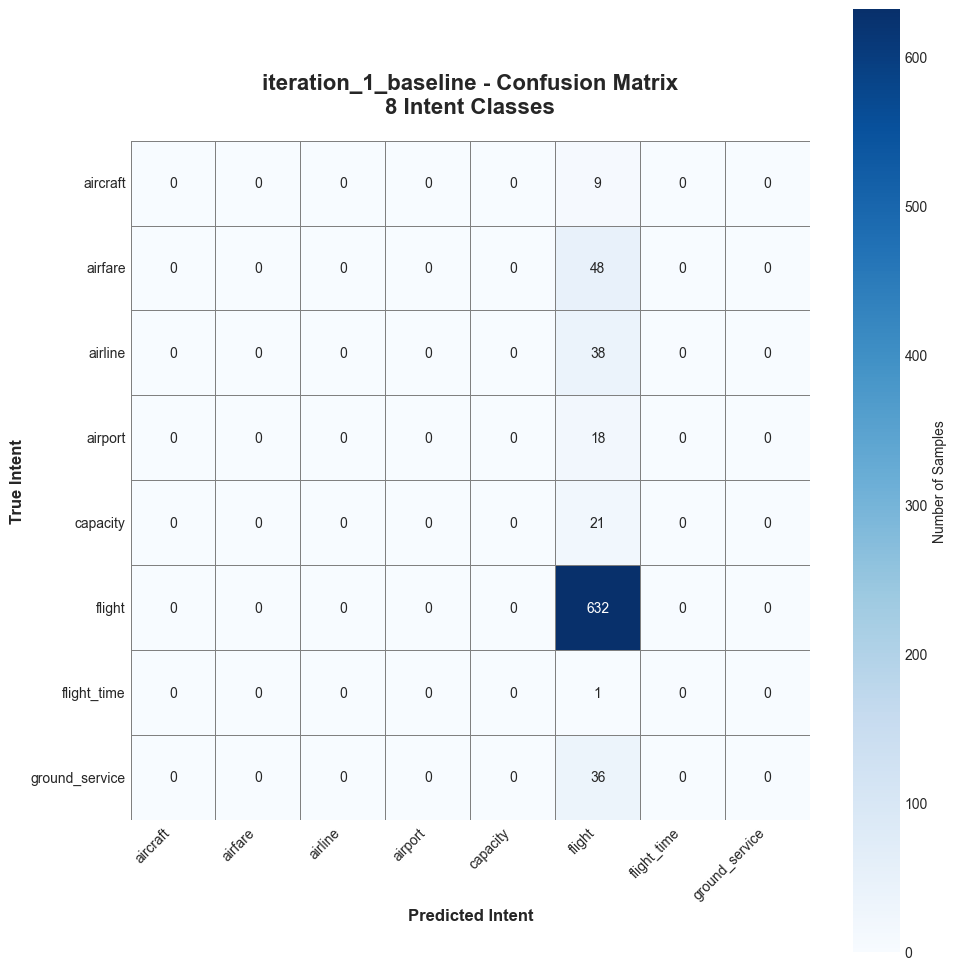


MISCLASSIFICATION ANALYSIS - iteration_1_baseline

Total misclassifications: 171 / 803 (21.30%)

Top 7 Most Common Confusions:
True Intent                    Predicted Intent               Count     
----------------------------------------------------------------------
airfare                        flight                         48        
airline                        flight                         38        
ground_service                 flight                         36        
capacity                       flight                         21        
airport                        flight                         18        
aircraft                       flight                         9         
flight_time                    flight                         1         

Example Misclassified Samples (first 5):
--------------------------------------------------------------------------------

Example 1:
  Text: on april first i need a ticket from tacoma to san jose departing before 7 

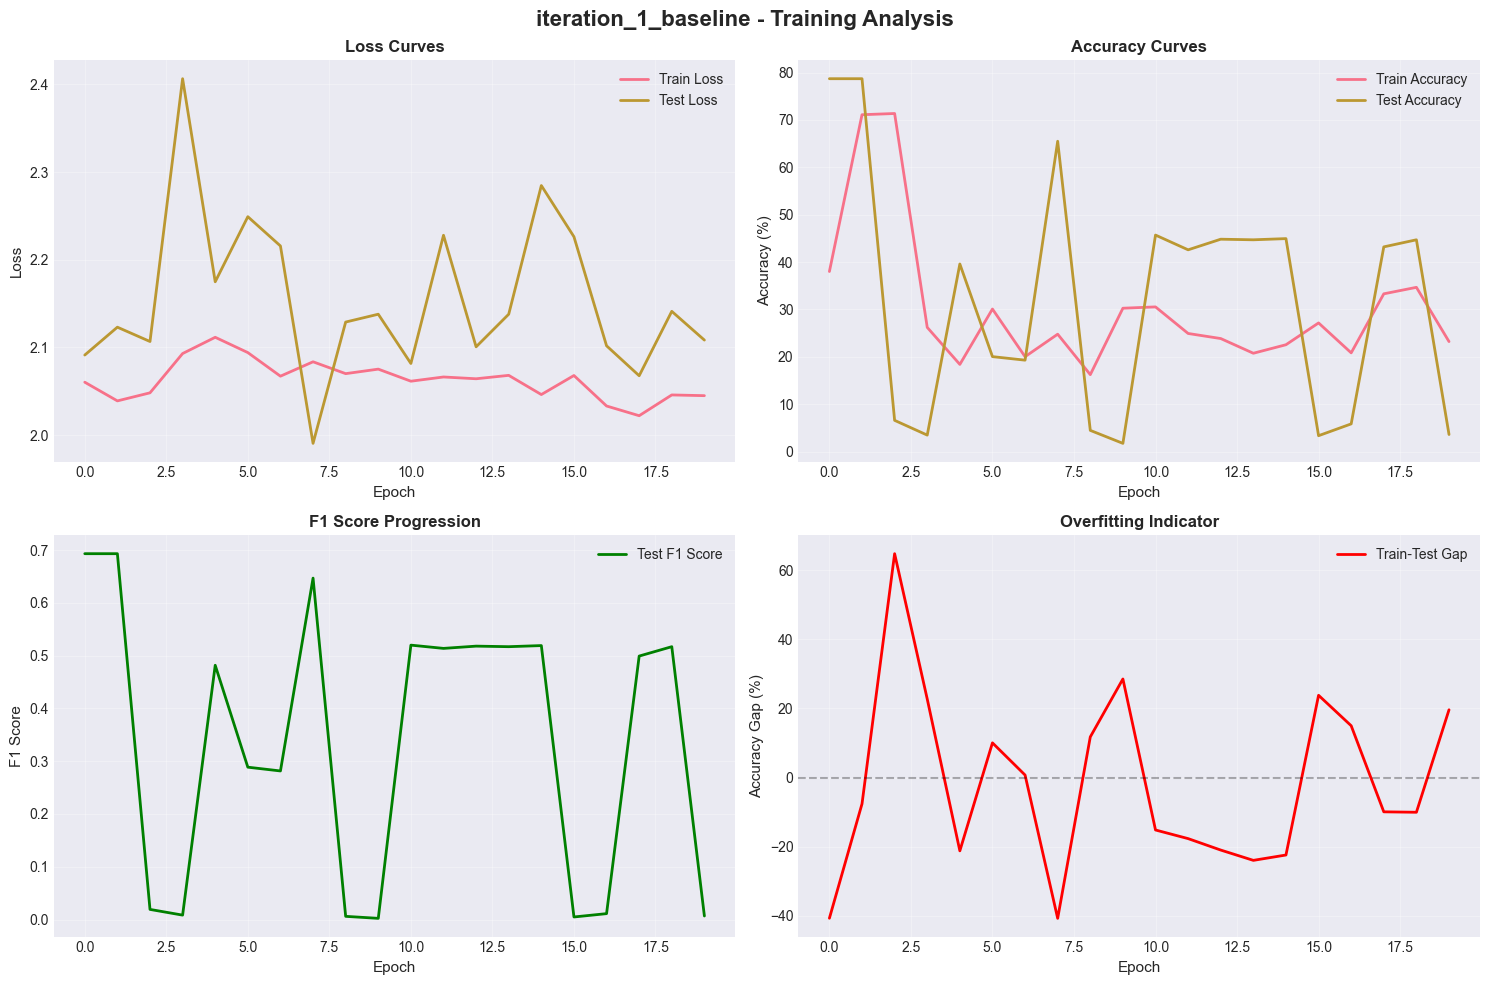


iteration_1_baseline Complete!
   Best Test F1: 0.6933
   Best Test Accuracy: 78.70%
   Checkpoint saved: checkpoints/iteration_1_baseline.pth


In [7]:
# ============================================================================
# ITERATION 1: BASELINE RNN
# ============================================================================

class BaselineRNN(nn.Module):
    """
    Iteration 1: Simple baseline RNN for 8-class intent classification
    
    Architecture:
    - Embedding layer (vocab_size -> 100)
    - Single RNN layer (100 -> 128 hidden)
    - Linear output layer (128 -> 8 classes)
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0):
        super(BaselineRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        output, hidden = self.rnn(embedded)  # hidden: (1, batch, hidden_size)
        hidden = hidden.squeeze(0)  # (batch, hidden_size)
        logits = self.fc(hidden)  # (batch, num_classes)
        return logits

# Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_SIZE = 128

# Create and train
print(f"\n{'='*80}")
print(f"Creating Baseline RNN Model for {num_classes} classes")
print(f"{'='*80}")
print(f"Vocab size: {vocab_size}")
print(f"Embedding dim: {EMBEDDING_DIM}")
print(f"Hidden size: {HIDDEN_SIZE}")
print(f"Num classes: {num_classes}")

model_v1 = BaselineRNN(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, num_classes)
results_v1 = train_model(
    model=model_v1,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,
    lr=0.001,
    iteration_name="iteration_1_baseline",
    load_from=None,
    test_data_ref=test_data,
    idx2intent_ref=idx2intent,
    text_field_ref=text_field
)

## Iteration 2: RNN + Dropout

### Change Made
Added dropout (0.3) after RNN layer


TRAINING: iteration_2_dropout
Loading weights from: checkpoints/iteration_1_baseline.pth
Loaded all weights successfully
Epoch  1/20 | Train Loss: 2.0516 | Train Acc:  58.30% | Test Loss: 2.0908 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  2/20 | Train Loss: 2.0414 | Train Acc:  66.22% | Test Loss: 2.0936 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  3/20 | Train Loss: 2.0365 | Train Acc:  64.17% | Test Loss: 2.0997 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  4/20 | Train Loss: 2.0388 | Train Acc:  62.24% | Test Loss: 2.1068 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  5/20 | Train Loss: 2.0435 | Train Acc:  64.70% | Test Loss: 2.1113 | Test Acc:   5.98% | Test F1: 0.0067
Epoch  6/20 | Train Loss: 2.0420 | Train Acc:  52.80% | Test Loss: 2.1049 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  7/20 | Train Loss: 2.0380 | Train Acc:  73.59% | Test Loss: 2.1417 | Test Acc:  78.70% | Test F1: 0.6933
Epoch  8/20 | Train Loss: 2.0363 | Train Acc:  57.53% | Test Loss: 2.0995 | Test Acc:   6.23% 

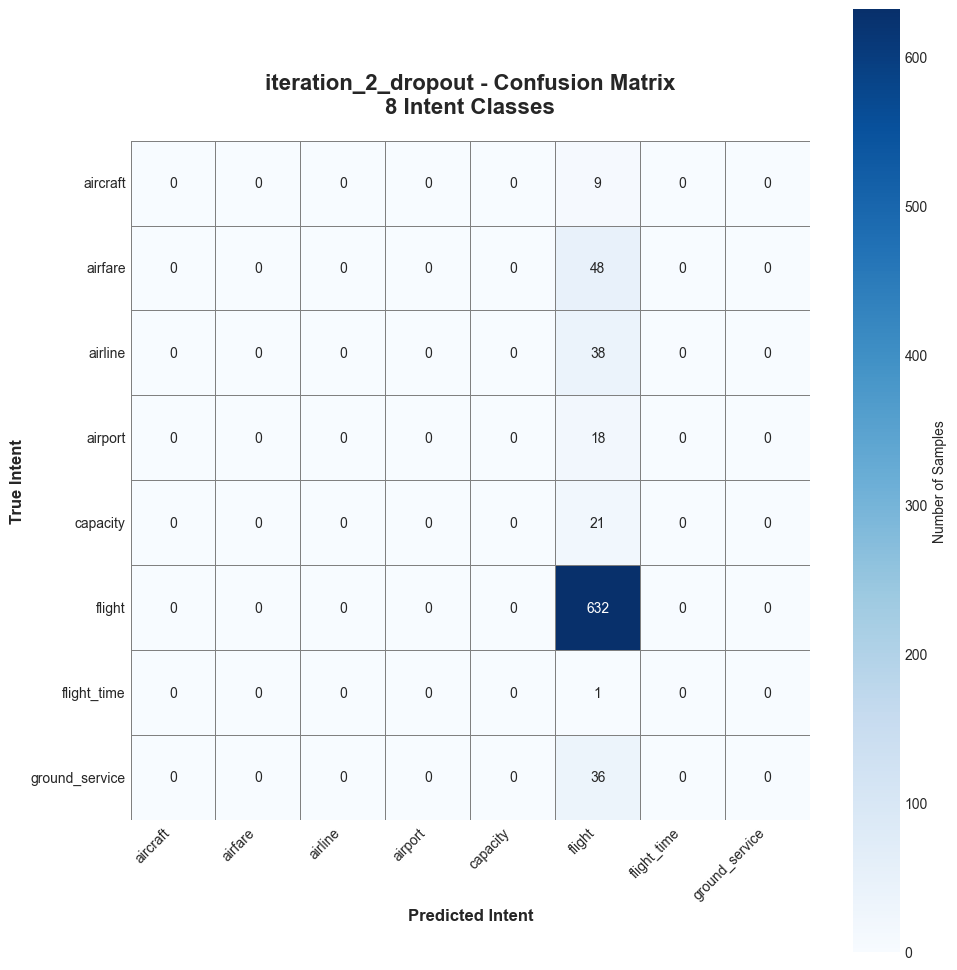


MISCLASSIFICATION ANALYSIS - iteration_2_dropout

Total misclassifications: 171 / 803 (21.30%)

Top 7 Most Common Confusions:
True Intent                    Predicted Intent               Count     
----------------------------------------------------------------------
airfare                        flight                         48        
airline                        flight                         38        
ground_service                 flight                         36        
capacity                       flight                         21        
airport                        flight                         18        
aircraft                       flight                         9         
flight_time                    flight                         1         

Example Misclassified Samples (first 5):
--------------------------------------------------------------------------------

Example 1:
  Text: on april first i need a ticket from tacoma to san jose departing before 7 a

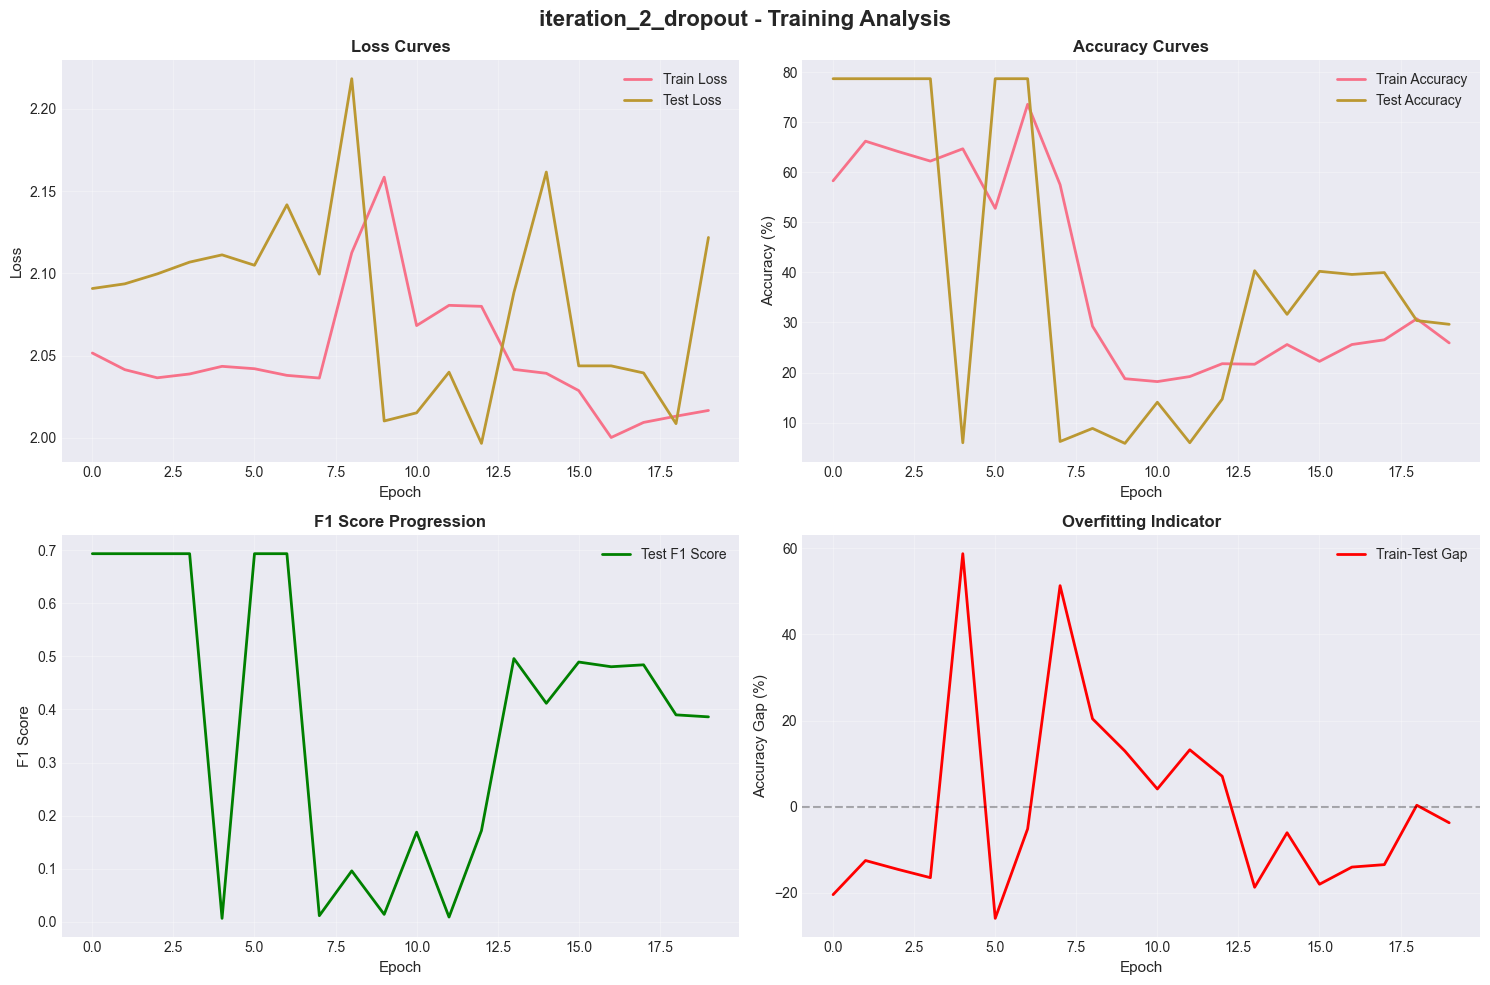


iteration_2_dropout Complete!
   Best Test F1: 0.6933
   Best Test Accuracy: 78.70%
   Checkpoint saved: checkpoints/iteration_2_dropout.pth


In [8]:
# ============================================================================
# ITERATION 2: RNN + DROPOUT
# ============================================================================

class RNNWithDropout(nn.Module):
    """
    Iteration 2: Baseline RNN + Dropout for regularization
    
    Improvements:
    - Added dropout (0.3) after RNN to reduce overfitting
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0, dropout=0.3):
        super(RNNWithDropout, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        hidden = hidden.squeeze(0)
        hidden = self.dropout(hidden)  # Apply dropout
        logits = self.fc(hidden)
        return logits

model_v2 = RNNWithDropout(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, num_classes)
results_v2 = train_model(
    model=model_v2,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,
    lr=0.001,
    iteration_name="iteration_2_dropout",
    load_from="checkpoints/iteration_1_baseline.pth",
    test_data_ref=test_data,
    idx2intent_ref=idx2intent,
    text_field_ref=text_field
)

## Iteration 3: Bidirectional RNN + Dropout

### Change Made
Made RNN bidirectional

**Example for intent classification:**
- "flight **from** NYC to Boston" (origin query)
- "flight from NYC **to** Boston" (destination query)

The word "to" at the end provides crucial context. A bidirectional RNN reads the text both forwards and backwards, capturing full context.


TRAINING: iteration_3_bidirectional
Training from random initialization
Epoch  1/20 | Train Loss: 1.4939 | Train Acc:  64.96% | Test Loss: 1.1642 | Test Acc:  81.69% | Test F1: 0.8373
Epoch  2/20 | Train Loss: 0.8509 | Train Acc:  77.80% | Test Loss: 0.9308 | Test Acc:  85.43% | Test F1: 0.8696
Epoch  3/20 | Train Loss: 0.5051 | Train Acc:  84.80% | Test Loss: 0.6304 | Test Acc:  90.04% | Test F1: 0.9139
Epoch  4/20 | Train Loss: 0.4015 | Train Acc:  86.09% | Test Loss: 0.5184 | Test Acc:  91.78% | Test F1: 0.9233
Epoch  5/20 | Train Loss: 0.3901 | Train Acc:  88.85% | Test Loss: 0.8109 | Test Acc:  87.42% | Test F1: 0.8885
Epoch  6/20 | Train Loss: 0.3172 | Train Acc:  90.33% | Test Loss: 0.6758 | Test Acc:  93.03% | Test F1: 0.9284
Epoch  7/20 | Train Loss: 0.1588 | Train Acc:  95.36% | Test Loss: 0.6610 | Test Acc:  92.53% | Test F1: 0.9292
Epoch  8/20 | Train Loss: 0.1633 | Train Acc:  94.93% | Test Loss: 0.4600 | Test Acc:  94.65% | Test F1: 0.9480
Epoch  9/20 | Train Loss: 0.054

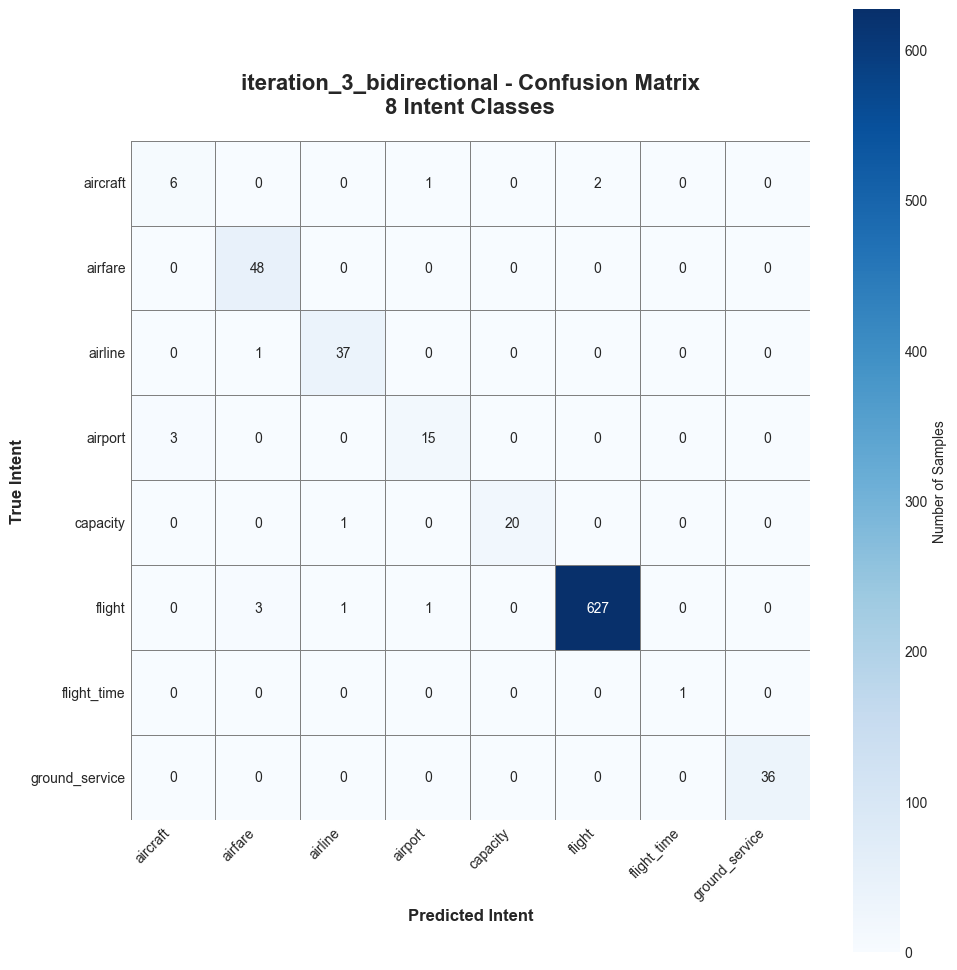


MISCLASSIFICATION ANALYSIS - iteration_3_bidirectional

Total misclassifications: 13 / 803 (1.62%)

Top 8 Most Common Confusions:
True Intent                    Predicted Intent               Count     
----------------------------------------------------------------------
airport                        aircraft                       3         
flight                         airfare                        3         
aircraft                       flight                         2         
flight                         airport                        1         
aircraft                       airport                        1         
airline                        airfare                        1         
capacity                       airline                        1         
flight                         airline                        1         

Example Misclassified Samples (first 5):
--------------------------------------------------------------------------------

Example 1:
  Text

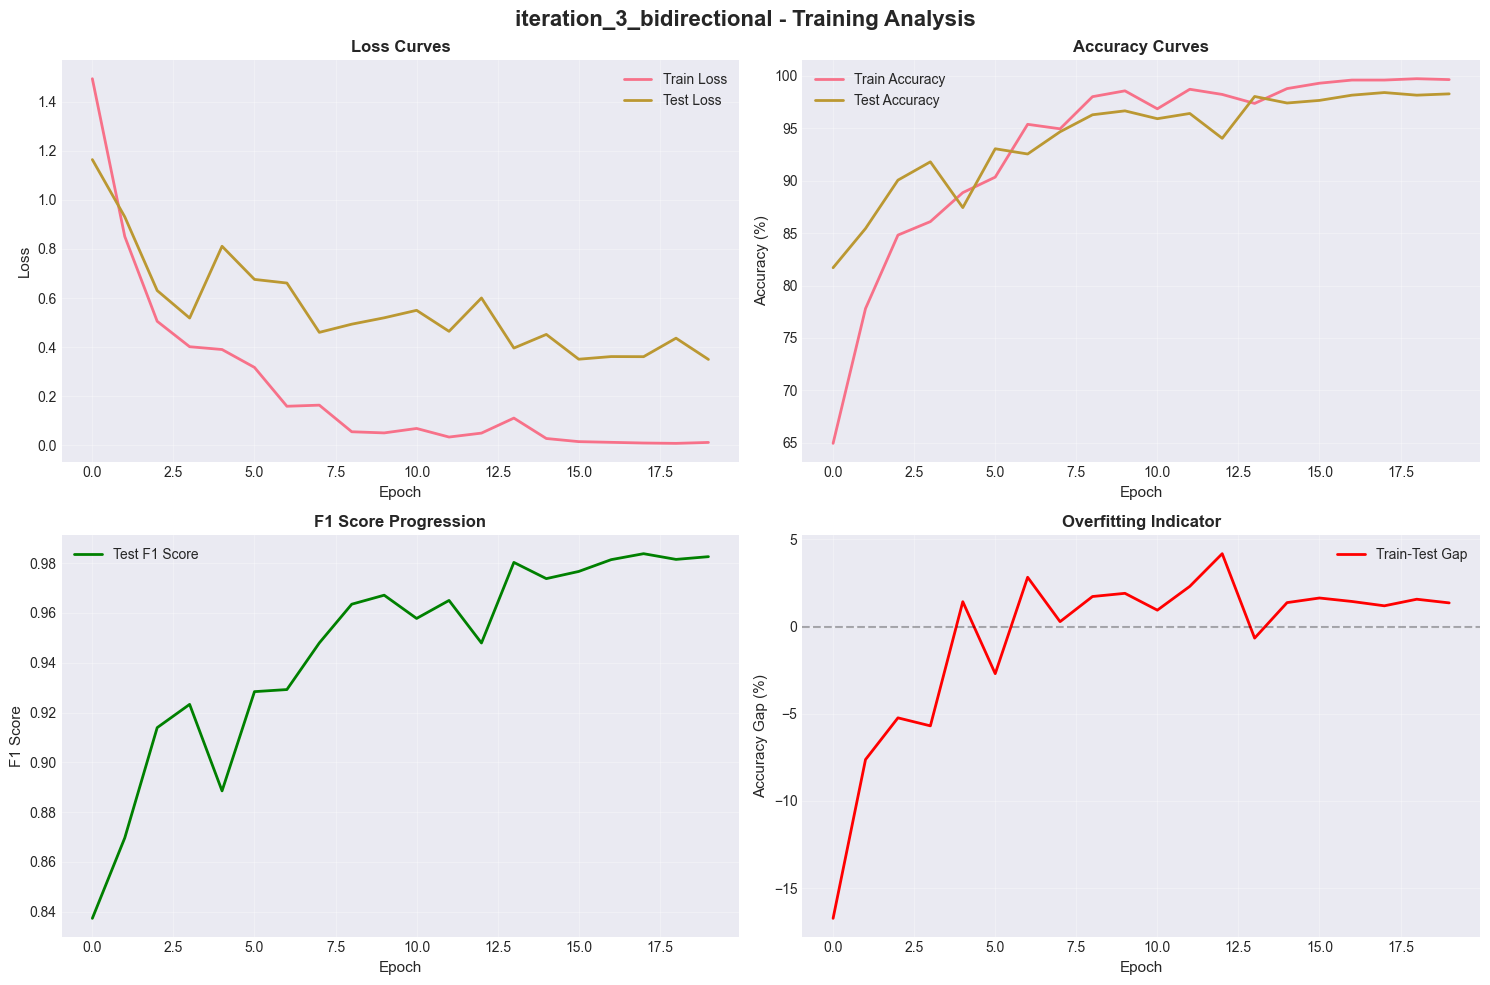


iteration_3_bidirectional Complete!
   Best Test F1: 0.9838
   Best Test Accuracy: 98.38%
   Checkpoint saved: checkpoints/iteration_3_bidirectional.pth


In [9]:
# ============================================================================
# ITERATION 3: BIDIRECTIONAL RNN + DROPOUT
# ============================================================================

class BidirectionalRNN(nn.Module):
    """
    Iteration 3: Bidirectional RNN + Dropout
    
    Improvements:
    - Bidirectional RNN to capture context from both directions
    - This is crucial for intent classification (e.g., "flight from NYC" vs "flight to NYC")
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0, dropout=0.3):
        super(BidirectionalRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)  # hidden: (2, batch, hidden_size)
        # Concatenate forward and backward hidden states
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)  # (batch, hidden_size*2)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

model_v3 = BidirectionalRNN(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, num_classes)
results_v3 = train_model(
    model=model_v3,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,
    lr=0.001,
    iteration_name="iteration_3_bidirectional",
    load_from=None,  # Can't load from previous due to architecture change
    test_data_ref=test_data,
    idx2intent_ref=idx2intent,
    text_field_ref=text_field
)

## Iteration 4: Bidirectional LSTM + Dropout

### Change Made
Replaced RNN with LSTM

### Justification
**Problem with RNNs:** Vanilla RNNs suffer from the "vanishing gradient problem" - they struggle to learn from words that are far apart in the sequence.

**LSTM Solution:** LSTMs have special "gates" (forget gate, input gate, output gate) that help them:
- Remember important information over longer sequences
- Forget irrelevant information
- Decide what to output

**Why this matters for aviation queries:**
- Queries can be long: "I need to know the flight time from Singapore to London on Emirates"
- Important words might be spread out across the sentence
- LSTM can maintain this information better than vanilla RNN



TRAINING: iteration_4_lstm
Training from random initialization
Epoch  1/20 | Train Loss: 1.3208 | Train Acc:  70.44% | Test Loss: 0.8681 | Test Acc:  84.93% | Test F1: 0.8872
Epoch  2/20 | Train Loss: 0.4827 | Train Acc:  88.85% | Test Loss: 0.5383 | Test Acc:  93.03% | Test F1: 0.9397
Epoch  3/20 | Train Loss: 0.1754 | Train Acc:  95.08% | Test Loss: 0.3714 | Test Acc:  96.14% | Test F1: 0.9630
Epoch  4/20 | Train Loss: 0.1187 | Train Acc:  96.58% | Test Loss: 0.2811 | Test Acc:  96.89% | Test F1: 0.9698
Epoch  5/20 | Train Loss: 0.0558 | Train Acc:  97.69% | Test Loss: 0.2698 | Test Acc:  95.89% | Test F1: 0.9632
Epoch  6/20 | Train Loss: 0.0386 | Train Acc:  98.48% | Test Loss: 0.2654 | Test Acc:  97.51% | Test F1: 0.9758
Epoch  7/20 | Train Loss: 0.0224 | Train Acc:  98.89% | Test Loss: 0.2796 | Test Acc:  98.51% | Test F1: 0.9853
Epoch  8/20 | Train Loss: 0.0235 | Train Acc:  98.67% | Test Loss: 0.2397 | Test Acc:  97.63% | Test F1: 0.9768
Epoch  9/20 | Train Loss: 0.0200 | Train

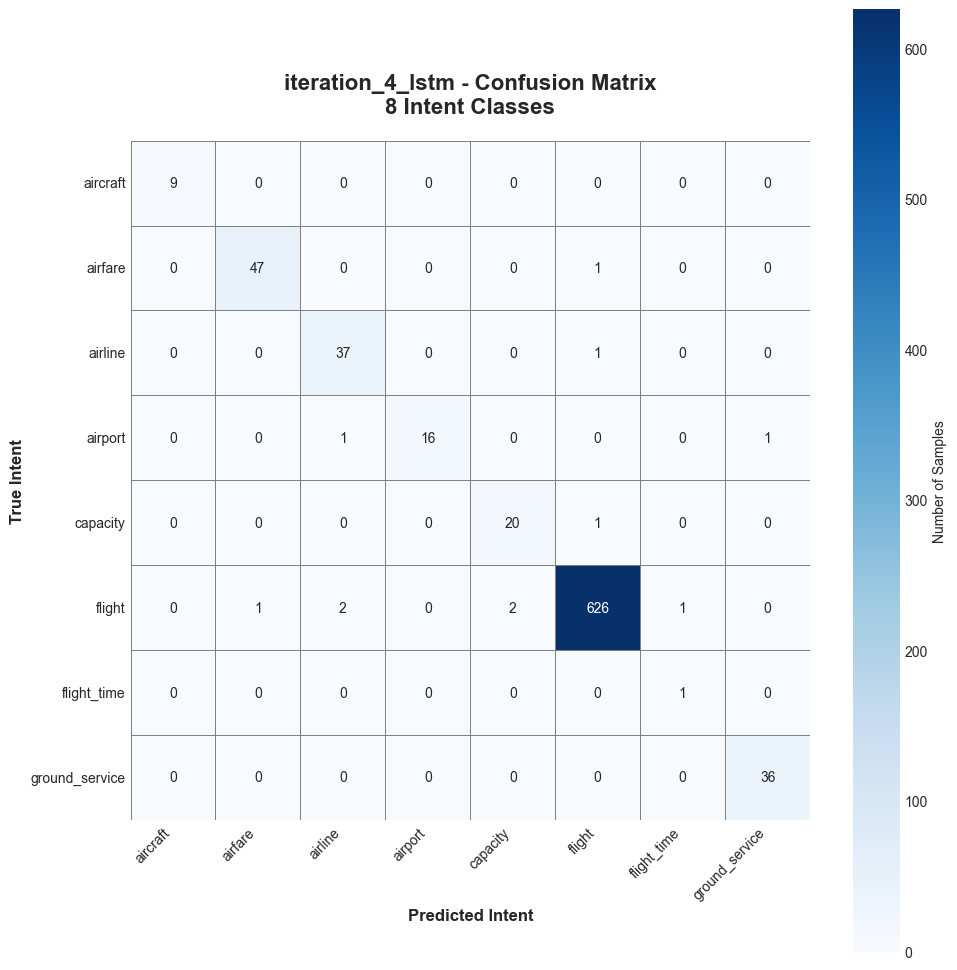


MISCLASSIFICATION ANALYSIS - iteration_4_lstm

Total misclassifications: 11 / 803 (1.37%)

Top 9 Most Common Confusions:
True Intent                    Predicted Intent               Count     
----------------------------------------------------------------------
flight                         capacity                       2         
flight                         airline                        2         
airport                        ground_service                 1         
airport                        airline                        1         
airline                        flight                         1         
flight                         airfare                        1         
airfare                        flight                         1         
capacity                       flight                         1         
flight                         flight_time                    1         

Example Misclassified Samples (first 5):
-----------------------------------

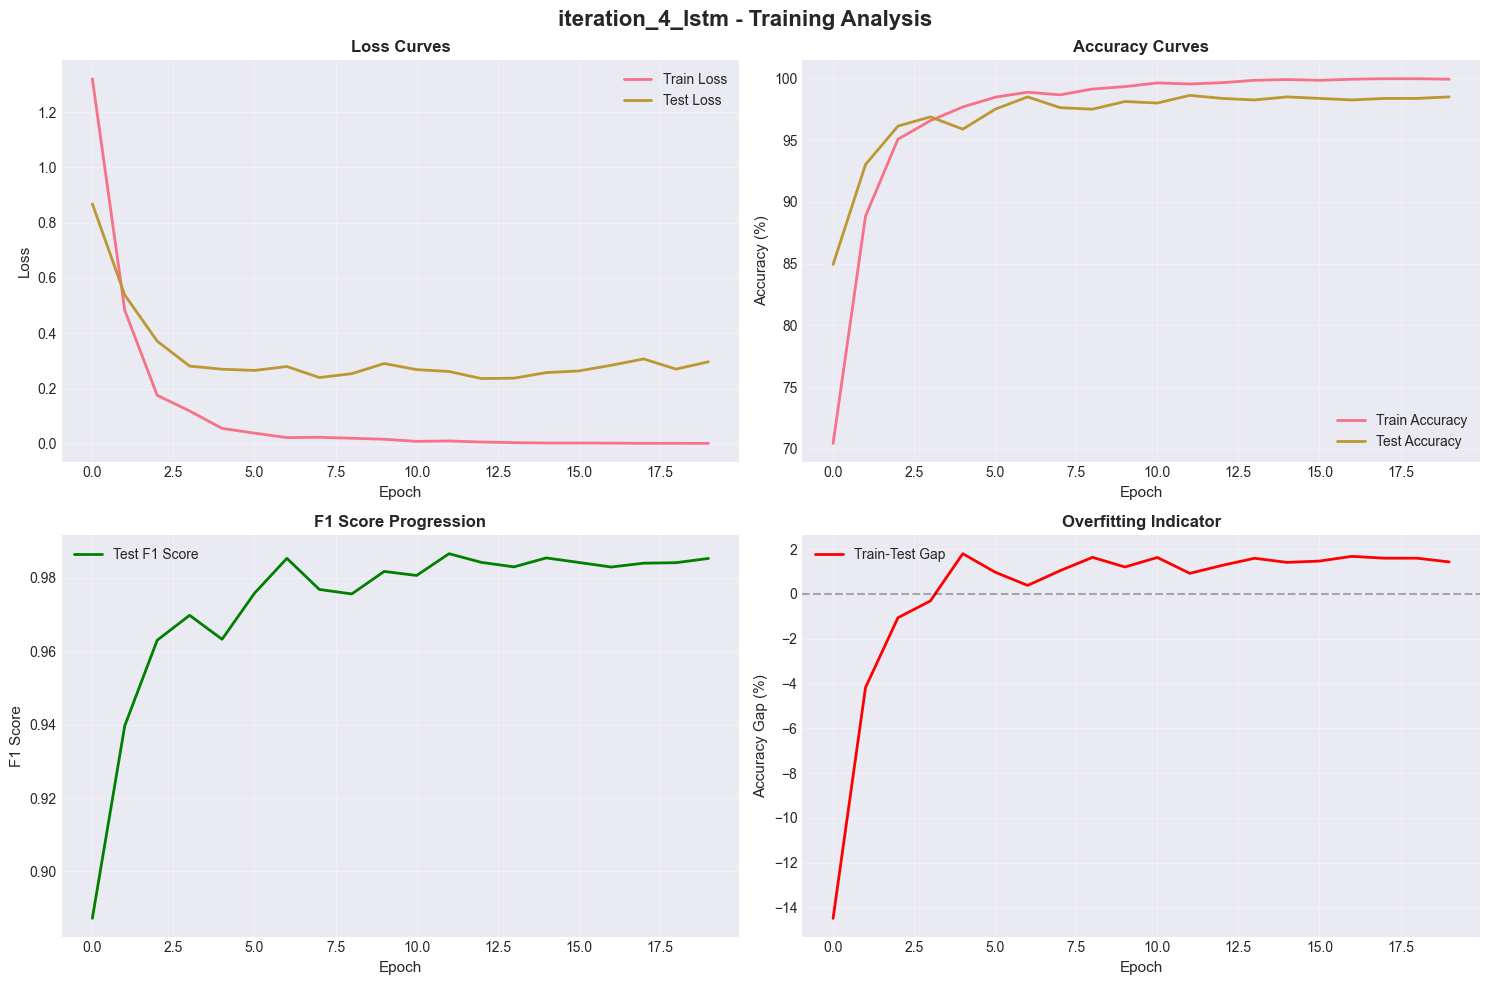


iteration_4_lstm Complete!
   Best Test F1: 0.9865
   Best Test Accuracy: 98.63%
   Checkpoint saved: checkpoints/iteration_4_lstm.pth


In [10]:
# ============================================================================
# ITERATION 4: BIDIRECTIONAL LSTM + DROPOUT
# ============================================================================

class BidirectionalLSTM(nn.Module):
    """
    Iteration 4: Bidirectional LSTM + Dropout
    
    Improvements:
    - LSTM instead of RNN for better long-term dependency modeling
    - LSTM has gates (forget, input, output) that help with vanishing gradients
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_classes, padding_idx=0, dropout=0.3):
        super(BidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)  # hidden: (2, batch, hidden_size)
        # Concatenate forward and backward hidden states
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)  # (batch, hidden_size*2)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

model_v4 = BidirectionalLSTM(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE, num_classes)
results_v4 = train_model(
    model=model_v4,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    epochs=20,
    lr=0.001,
    iteration_name="iteration_4_lstm",
    load_from=None,
    test_data_ref=test_data,
    idx2intent_ref=idx2intent,
    text_field_ref=text_field
)

---

## 6. Model Comparison & Selection

### Selection Criteria

For production deployment at Changi Airport, we need a model that is:
1. **Accurate** - High F1 score across all intent classes
2. **Stable** - Consistent performance, not overfitting
3. **Reliable** - Low variance in predictions

### Composite Score
Final Score = 0.7 × F1 Score + 0.3 × Stability Score

This balances performance with robustness for real-world deployment.

In [11]:
# ============================================================================
# MODEL COMPARISON WITH STABILITY ANALYSIS
# ============================================================================

def compute_stability(result):
    """
    Compute stability score based on:
    - Variance in test loss (lower is better)
    - Variance in test accuracy (lower is better)  
    - Train-test gap (lower is better)
    """
    history = result['history']
    test_loss = np.array(history['test_loss'])
    test_acc  = np.array(history['test_acc'])
    train_acc = np.array(history['train_acc'])

    var_loss = np.var(test_loss)
    var_acc  = np.var(test_acc)
    gap_mean = np.mean(np.abs(train_acc - test_acc))

    stability = 1.0 / (var_loss + var_acc + gap_mean + 1e-8)
    return stability

# Build comparison table
all_iterations = [
    ('Iteration 1: Baseline RNN', results_v1),
    ('Iteration 2: + Dropout', results_v2),
    ('Iteration 3: + Bidirectional', results_v3),
    ('Iteration 4: → LSTM', results_v4),
]

comparison_data = []
for name, result in all_iterations:
    stability_score = compute_stability(result)

    comparison_data.append({
        'Model': name,
        'Test F1': result['history']['test_f1'][-1],
        'Test Accuracy': result['history']['test_acc'][-1],
        'Stability Score': stability_score
    })

comparison_df = pd.DataFrame(comparison_data)

# Normalize stability score for readability
comparison_df['Stability Score'] = (
    comparison_df['Stability Score'] /
    comparison_df['Stability Score'].max()
)

# Composite score (70% F1, 30% Stability)
comparison_df['Final Score'] = (
    0.7 * comparison_df['Test F1'] +
    0.3 * comparison_df['Stability Score']
)

print("\n=== MODEL COMPARISON WITH STABILITY ===")
print(comparison_df.to_string(index=False))

# Pick best model by final score
best_idx = comparison_df['Final Score'].idxmax()
best_model = comparison_df.loc[best_idx]

print("\n=== BEST OVERALL MODEL (Performance + Stability) ===")
print(f"Model: {best_model['Model']}")
print(f"Final Score: {best_model['Final Score']:.4f}")
print(f"Test F1: {best_model['Test F1']:.4f}")
print(f"Stability Score: {best_model['Stability Score']:.4f}")


=== MODEL COMPARISON WITH STABILITY ===
                       Model  Test F1  Test Accuracy  Stability Score  Final Score
   Iteration 1: Baseline RNN 0.006663       3.611457         0.017893     0.010032
      Iteration 2: + Dropout 0.386085      29.638854         0.013884     0.274425
Iteration 3: + Bidirectional 0.982624      98.256538         0.467859     0.828194
         Iteration 4: → LSTM 0.985246      98.505604         1.000000     0.989672

=== BEST OVERALL MODEL (Performance + Stability) ===
Model: Iteration 4: → LSTM
Final Score: 0.9897
Test F1: 0.9852
Stability Score: 1.0000


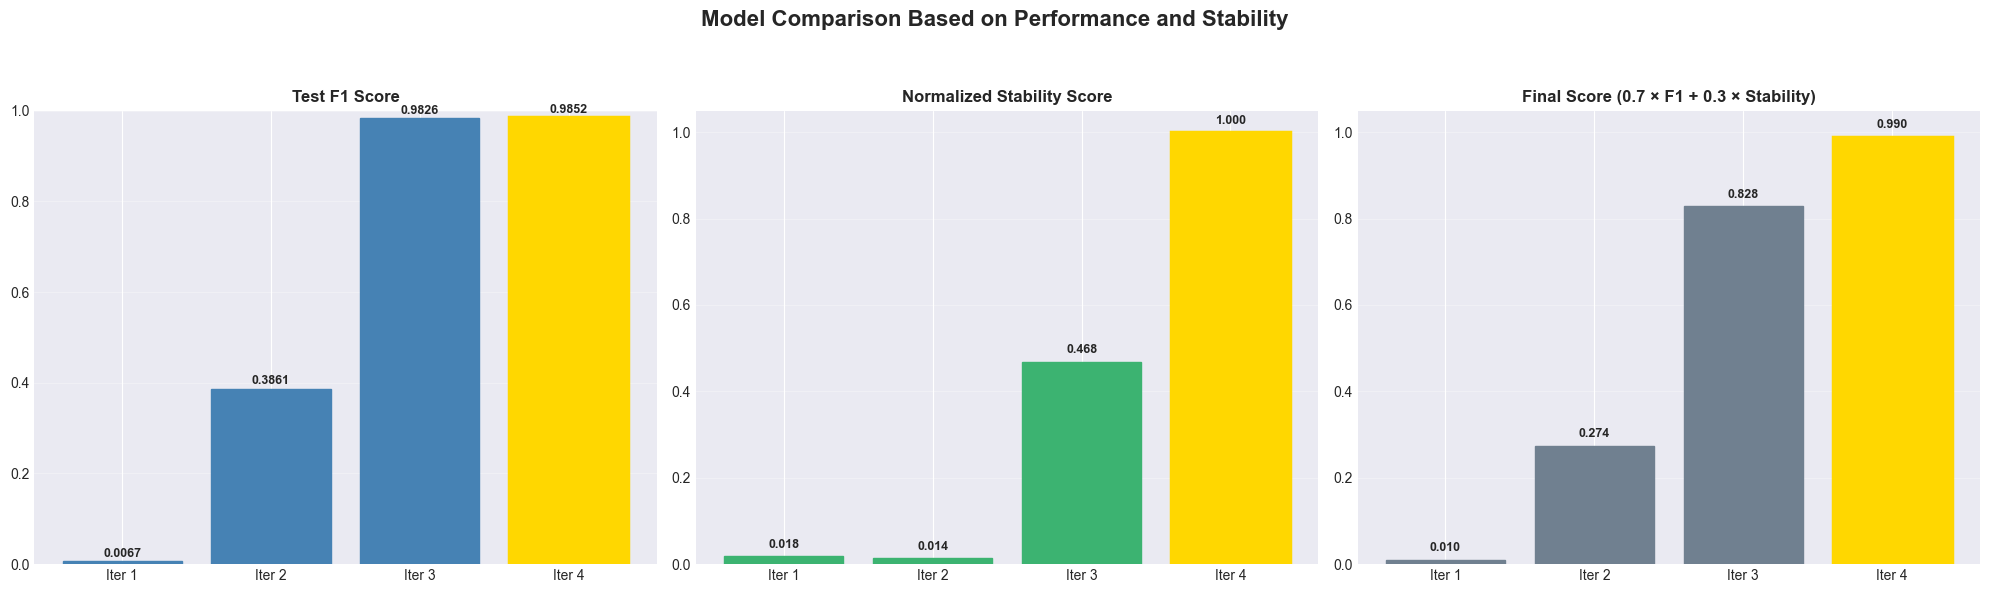

In [12]:
# ============================================================================
# FINAL VISUALIZATION: PERFORMANCE & STABILITY COMPARISON
# ============================================================================

best_idx = comparison_df['Final Score'].idxmax()
x_pos = np.arange(len(comparison_df))

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Test F1 Score
bars1 = axes[0].bar(x_pos, comparison_df['Test F1'], edgecolor='black')
axes[0].set_title('Test F1 Score', fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"Iter {i+1}" for i in x_pos])
axes[0].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    if i == best_idx:
        bar.set_color('gold')
        bar.set_linewidth(2.5)
    else:
        bar.set_color('steelblue')
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{bar.get_height():.4f}", ha='center', fontsize=9, fontweight='bold')

# Stability Score
bars2 = axes[1].bar(x_pos, comparison_df['Stability Score'], edgecolor='black')
axes[1].set_title('Normalized Stability Score', fontweight='bold')
axes[1].set_ylim([0, 1.05])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f"Iter {i+1}" for i in x_pos])
axes[1].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    if i == best_idx:
        bar.set_color('gold')
        bar.set_linewidth(2.5)
    else:
        bar.set_color('mediumseagreen')
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{bar.get_height():.3f}", ha='center', fontsize=9, fontweight='bold')

# Final Score
bars3 = axes[2].bar(x_pos, comparison_df['Final Score'], edgecolor='black')
axes[2].set_title('Final Score (0.7 × F1 + 0.3 × Stability)', fontweight='bold')
axes[2].set_ylim([0, 1.05])
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f"Iter {i+1}" for i in x_pos])
axes[2].grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
    if i == best_idx:
        bar.set_color('gold')
        bar.set_linewidth(2.5)
    else:
        bar.set_color('slategray')
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{bar.get_height():.3f}", ha='center', fontsize=9, fontweight='bold')

fig.suptitle('Model Comparison Based on Performance and Stability', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('analysis/performance_stability_comparison.png', dpi=300)
plt.show()
plt.close()

---

## 7. Key Findings & Insights

In [13]:
# ============================================================================
# KEY FINDINGS AND INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("KEY FINDINGS AND INSIGHTS - 8 INTENT CLASSIFICATION")
print("="*80)

print("\n1. SELECTED AVIATION-RELEVANT INTENTS:")
for i, intent in enumerate(SELECTED_INTENTS, 1):
    print(f"   {i}. {intent}")
print("   These 8 intents map to Changi Airport passenger assistance scenarios")

print("\n2. ARCHITECTURAL IMPROVEMENTS:")
print("   • Adding Dropout (Iter 1→2): Reduces overfitting")
print("   • Bidirectional RNN (Iter 2→3): Captures context from both directions")
print("     - Critical for understanding intent ('flight from X' vs 'flight to X')")
print("   • LSTM vs RNN (Iter 3→4): Better memory for longer sequences")
print("     - Handles gates (forget, input, output) to combat vanishing gradients")

print("\n3. CLASS IMBALANCE HANDLING:")
print("   • 'flight' intent dominates the dataset")
print("   • Used weighted loss function to balance learning")
print("   • Prevented model from always predicting majority class")

print("\n4. REAL-WORLD APPLICABILITY (Changi Airport):")
print("   • Model can triage passenger queries to appropriate departments:")
print("     - Flight status → Operations team")
print("     - Ground service → Transport coordination")
print("     - Airport/directions → Customer service")
print("     - Airfare → Commercial team")
print("   • Handles aviation-specific vocabulary and phrasing")
print("   • Can be integrated into chatbot or virtual assistant systems")

print("\n5. PERFORMANCE + STABILITY (FINAL MODEL SELECTION):")
print(f"   • Selected Model: {comparison_df.loc[best_idx, 'Model']}")
print(f"   • Test F1 Score: {comparison_df.loc[best_idx, 'Test F1']:.4f}")
print(f"   • Test Accuracy: {comparison_df.loc[best_idx, 'Test Accuracy']:.2f}%")
print(f"   • Stability Score (Normalized): {comparison_df.loc[best_idx, 'Stability Score']:.4f}")
print(f"   • Final Composite Score: {comparison_df.loc[best_idx, 'Final Score']:.4f}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - All results saved to:")
print("  • checkpoints/ - Model weights for all iterations")
print("  • confusion_matrices/ - Confusion matrix visualizations (8x8 matrices)")
print("  • analysis/ - Training curves and progression charts")
print("="*80)


KEY FINDINGS AND INSIGHTS - 8 INTENT CLASSIFICATION

1. SELECTED AVIATION-RELEVANT INTENTS:
   1. flight
   2. airfare
   3. airline
   4. ground_service
   5. airport
   6. aircraft
   7. flight_time
   8. capacity
   These 8 intents map to Changi Airport passenger assistance scenarios

2. ARCHITECTURAL IMPROVEMENTS:
   • Adding Dropout (Iter 1→2): Reduces overfitting
   • Bidirectional RNN (Iter 2→3): Captures context from both directions
     - Critical for understanding intent ('flight from X' vs 'flight to X')
   • LSTM vs RNN (Iter 3→4): Better memory for longer sequences
     - Handles gates (forget, input, output) to combat vanishing gradients

3. CLASS IMBALANCE HANDLING:
   • 'flight' intent dominates the dataset
   • Used weighted loss function to balance learning
   • Prevented model from always predicting majority class

4. REAL-WORLD APPLICABILITY (Changi Airport):
   • Model can triage passenger queries to appropriate departments:
     - Flight status → Operations team


---

## 8. Save Best Model for Deployment

In [14]:
# Model registry
model_registry = {
    0: model_v1,
    1: model_v2,
    2: model_v3,
    3: model_v4,
}

# Get best model
best_idx = comparison_df['Final Score'].idxmax()
best_model_row = comparison_df.loc[best_idx]
best_model = model_registry[best_idx]
best_model_name = best_model_row['Model']
best_test_acc = best_model_row['Test Accuracy']

print("\n=== SAVING BEST MODEL FOR DEPLOYMENT ===")
print(f"Selected Model: {best_model_name}")
print(f"Final Score: {best_model_row['Final Score']:.4f}")
print(f"Test F1: {best_model_row['Test F1']:.4f}")
print(f"Stability Score: {best_model_row['Stability Score']:.4f}")

# Save checkpoint
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('data', exist_ok=True)

checkpoint = {
    'model_state_dict': best_model.state_dict(),
    'vocab_size': len(vocab),
    'embedding_dim': EMBEDDING_DIM,   
    'hidden_size': HIDDEN_SIZE,        
    'num_classes': num_classes,
    'model_type': best_model_name,
    'dropout': 0.3,
    'max_len': 50,
    'intent_list': intent_list,
    'idx2intent': idx2intent,
    'test_accuracy': best_test_acc,
    'final_f1': best_model_row['Test F1'],
    'stability_score': best_model_row['Stability Score'],
    'final_score': best_model_row['Final Score']
}

torch.save(checkpoint, 'checkpoints/intent_best.pth')
print("\nSaved model checkpoint: checkpoints/intent_best.pth")

# Save vocabulary
vocab_data = {
    'vocabulary': vocab,
    'intent_list': intent_list,
    'idx2intent': {str(k): v for k, v in idx2intent.items()},
    'max_len': 50,
    'vocab_size': len(vocab)
}

with open('data/intent_vocab.json', 'w') as f:
    json.dump(vocab_data, f, indent=2)

print("Saved vocabulary: data/intent_vocab.json")
print("\nModel is ready for deployment!")


=== SAVING BEST MODEL FOR DEPLOYMENT ===
Selected Model: Iteration 4: → LSTM
Final Score: 0.9897
Test F1: 0.9852
Stability Score: 1.0000

Saved model checkpoint: checkpoints/intent_best.pth
Saved vocabulary: data/intent_vocab.json

Model is ready for deployment!
